# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 Task 1 - Reinforcement Learning from the Screen Frames

---


## Imports

In [ ]:
# OpenAI has preprocessing modules in their baselines repository 
# such as FrameStack, NoopResetEnv, episode_life, etc.
# To import those we first need to install the OpenAI baseline package
# via running this code cell.
!pip install git+https://github.com/openai/baselines.git

In [2]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym

# The frame stack size
FRAME_STACK_SIZE = 5

# Make the Atari game and its environment assign it to
# a variable for later use (RL of the DDQN agent).
env = gym.make("Asterix-v0")

# Preprocess the environment (downsampling to 84x84 and
# scaling the input image pixels of the game)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)

# Stack the input image frames by FRAME_STACK_SIZE
env = FrameStack(env, FRAME_STACK_SIZE)

# Seed the Atari game environment
env.seed(SEED_VALUE)

[1337, 17452119]

## Task 1.1

In [ ]:
class RandomAgent():
    """
    RandomAgent class used for creating agent instances, which only explore the
    game environment via random actions (without learning anything about it).
    Args:
        env (AtariEnv): Atari game environment
    """
    def __init__(self, env):
        """Initialise a list of possible agent actions for the environment. 
        These are taken from the environment's action space.
        """
        self.action_space = env.action_space.n
        
    def get_action(self, observation):
        """Return a random actions
        """
        return random.choice(range(self.action_space))

# Total agent reward
total_reward = 0

# Instantiate a RandomAgent object
random_agent = RandomAgent(env)

# Number of episodes to train the agent
NUM_OF_EPISODES = 1
 
# Loop over the number of episodes and 
for steps in range(NUM_OF_EPISODES):
    # Reset the game environment
    current_obs = env.reset()
    
    # Take actions and explore the environment 
    # while the agent still has lives left (done=False)
    done = False
    while not done:
        action = random_agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        
        # Increment the total reward of the random agent
        total_reward += reward
        
        env.render()
env.close()
print("Average reward: {}".format(total_reward/NUM_OF_EPISODES))

In [3]:
# Print the observation and action spaces, and the Atari 
# game action space and their names (meanings)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())
# print('Info dictionary:', env.step(action)[3])
# print('Reward:', env.step(action)[1])

Observation space: Box(84, 84, 5)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


To display this, a simple agent that performs random actions for one episode is implemented.

- **Observations**: `env.observation_space` shows that the obseravtion space is an RGB image of which is an array of shape $(210, 160, 3)$, indicating a height of $210$ pixels, a width of $160$ pixels and $3$ channels.


- **Action Space**: `env.action_space` shows us that the action space is *discrete* with $9$ possible actions that are printed out for better understanding using `env.unwrapped.get_action_meanings()`. Each action is performed repeatedly for a duration of $k$ frames, where $k$ is sampled from the set ${2,3,4}$ uniformly. The discrete space allows for a fixed range of non-negative numbers, where low (`env.observation_space.low`) will be a grid filled with zeros $(0\times0\times0)$ and high (`env.observation_space.high`) will be a grid filled with $250\times250\times250$.


- **Reward**: $0$ but is accumulated as an episode is played and the player collects cauldrons and items giving him points. 


- **Environment's info dictionary**: The info dictionary contains `ale.lives()` which refers to the number of lives left. In our case, the player has only $3$ lives that decrease as he collides with the lyres.


- **Episode**: An episode is concluded when the player loses a life. When a game is played and `done=True`, this indicates that the game is finished and the player has lost all lives. 




## Task 1.2

Please refer to the report for this task.

## Task 1.3

We are using a special wrapper for the purpose of environment preprocessing. 

This reshapes the image to .... and the agent will receive a grayscale observation as we have converted the observarions to grayscale. We also scale all observations to `[0,1]`.

Another common preprocessing step is the introductioon of frame skipping (Naddaf, 2010 at https://era.library.ualberta.ca/items/a661eb66-f2e0-4ed3-b501-b6cbcd1fdd9d), which is what restricts the agent's decision points by repeating some selected action for $k$ consequitve frames, making the RL problem simpler and speeding up execution. 

This notebook follows an approach where the agent is designed with a richer observation space by combining past frames with most recent ones as known as frame stacking (Mnih et al., 2015 https://www.nature.com/articles/nature14236). We use $5$ frames, but the algorithm might also be robust with different values such as 3 or 4. This research experimented with all 3 options and concluded that the use of 5 images in a stack is the most beneficial approach with regards to total reward. Due to this reduction in partial observability, the agent can detect the direction of motion of in-game objects.




(84, 84, 5)


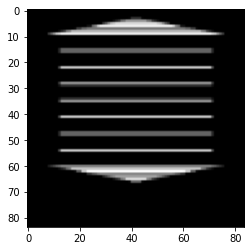

In [4]:
# Print the game image shape and plot a sample 
# image for illustration purposes
obs = env.reset()
print(env.observation_space.shape)
plt.imshow(obs[:,:,0], cmap='gray')
plt.show()

Please refer to the report for a more indepth explanation.

## Task 1.4

In [5]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Defining global variable and importing packages for training the models

In [6]:
# Import the Keras layer used for building our DDQN models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

# Get the input shape for the DDQN models (game environment observation space)
INPUT_SHAPE = env.observation_space.shape

# Get the output shape for the DDQN models
NUM_ACTIONS = env.action_space.n

# Set the batch size
BATCH_SIZE = 32

# Set the DDQN agent memory size.
# We use a relatively small value due to assessment time constraints
# and also to provide easier reproducibility. ===================================
MEMORY_SIZE = 25000

# Define the exploration steps of the DDQN agent.
# We do not train the model during these first steps.
EXPLORATION_STEPS = 20000

# Define the learning rate to be used for the model
# gradient descent optimisation method (Adam as opposed to RMSprop) WHY ADAM??===============================
LEARNING_RATE = 0.00025

In [7]:
class SumTree:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    Args:
        capacity (int): size of the sum tree
    """
    # The data pointer class variable
    write = 0

    def __init__(self, capacity):
        """Initialize the tree with all nodes and data with values set to 0.
        """
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Store the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        """Recursively propagate a given child node change through the sum tree.
        """
        
        # Get the parent node index
        parent = (idx - 1) // 2
        
        # Apply the child node change to the parent node
        self.tree[parent] += change
        
        # Do this until the root node is reached
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """Return a leaf node (priority) index for the current experience (observation)
        """
        
        # Get the left and right child node indexes
        # for the current sample
        left = 2 * idx + 1
        right = left + 1
        
        # Return the index itself if the 
        # left child index is greater than the 
        # capacity of the sum tree
        if left >= len(self.tree):
            return idx
        
        # Start recursion
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """Return the root node (total sum of the experience priority values).
        """
        return self.tree[0]

    def add(self, p, data):
        """Add the experience and its priority score (as a leaf) to the sum tree.
        """
        # Get the tree index for the experience (observation)
        idx = self.write + self.capacity - 1
        
        # Update the sum tree data
        self.data[self.write] = data
        
        # Update the sum tree probability values
        self.update(idx, p)
        
        # Increment the data pointer
        self.write += 1
        
        # If over the capacity, go back to first index (we overwrite)
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        """Update the leaf priority score and propagate the change through tree.
        """
        # Change = new priority score - former priority score
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change through tree
        self._propagate(idx, change)

    def get(self, s):
        """Return the leaf index, priority value and its associated experience (observation).
        """
        # Get the leaf index
        idx = self._retrieve(0, s)
        
        # Get the experience (observation) index
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

#-------------------- MEMORY --------------------------
class Memory:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    
    Args:
        capacity (int): size of the sum tree
    """
    # Hyperparameter to avoid assigning 0 probability to experiences
    e = 0.01
    
    # Hyperparameter to make a trade-off between random sampling and taking a
    # a high priority experience (observation)
    a = 0.6

    def __init__(self, capacity):
        """Initialise the sum tree with the given capacity.
        """
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """Store a new experience in the tree along with its corresponding priority value.
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Store the priority and the experience (observation)
        self.tree.add(p, sample) 

    def sample(self, n):
        """Sample a n-sized batch of priority index and observation pair.
        """
        # Create a list to hold the batch pairs
        batch = []
        
        # Calculate and store the priority segment
        segment = self.tree.total() / n
        
        # Populate the batch list
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        """Update the sum tree leaves (priorities).
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Update the sum tree probability values
        self.tree.update(idx, p)

In [8]:
# Import the math Python package
import math

# Minimum and maximum epsilon value constants
MAX_EPSILON = 1
MIN_EPSILON = 0.1

# Constant that determines the speed of the epsilon decay
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS 

class DDQNAgent():
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an DDQ Network and Agent experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/jaromiru/AI-blog
    
    Args:
        env (AtariEnv): the environment that RLNetwork and Agent are optimized on
        lr (float): learning rate of the network
    """
    steps = 0
    
    def __init__(self, env, lr=LEARNING_RATE):
        """Initialise the agent and the online and target DDQNs for the environment.
        """
        self.lr = lr
        
        self.memory = Memory(MEMORY_SIZE)
        
        # Set the initial DDQN models loss value to be +inf
        self.loss_val = np.inf
        self.action_space = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99

        # Create the two networks for predicting the actions
        
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 10,000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64):
        """Define and return the CNN model architecture.
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(256, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights.
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        """Based on the Epsilon agent chooses wheter to explore or exploatate
        """
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_space)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_space)# random action
            else:
                q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        """Decide on the input, desired output and error of the current state.
        """
        
        # NumPy array storing no observation space
        # used at the end of each episode (improved performance)
        no_state = np.zeros(INPUT_SHAPE)
        
        # Get the previous states from the batch observations
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # Get the next states from the batch observations
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
        
        # Make predictions based on the previous states
        # using the online model
        prev_q_vals = self.online.predict(prev_states)
        
        # Make predictions based on the next states
        # using the online model (used in the function for 
        # calculating the future q values of the DDQN)
        next_q_vals_double = self.online.predict(next_states)
        
        # Make predictions based on the next states
        # using the target model
        next_q_vals = self.target.predict(next_states)
        
        # Create NumPy arrays for storing the previous states and future q values,
        # and the calculated error values (used for determining state priorities)
        # respectively
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            # Get the current (previous/old) state q value
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value is the current q val
            # which is to be updated using the predictions of
            # both the online and the target models
            future_q_val = q_val
            
            # Update the future q value
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            # Populate the previous state and future q value lists 
            X[idx] = curr_state
            Y[idx] = future_q_val
            
            # Calculate the error values for each experience (observation)
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done, step):
        """Update the sum tree priorities and observations (samples).
        """
        sample = (curr_state, action, reward, next_state, done)
        if step <= EXPLORATION_STEPS:
            error = abs(sample[2])  # Reward
            self.memory.add(error, sample)
        else:
            X, Y, errors = self.get_train_data([(0, sample)])
            self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value.
        """
        
        # Sample a batch error-observation pairs
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        # Fit the online DDQN and update the loss value
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


Please refer to the report for further information regarding the deployment and parameter adjustments of the agent.

## Task 1.5

In [9]:
import time

# Initialise the DDQN agent 
ddqn_agent = DDQNAgent(env)  

# Lists to hold the steps and their corresponding rewards respectively 
ep_steps, ep_rewards = [], []

# To hold the total episode reward of the agent
total_reward = 0

# Total number of training steps
N_STEPS = 1000000  

# Train the model after 4 actions
TRAIN_ONLINE_STEPS = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
UPDATE_TARGET_STEPS = 10000

# Start the DDQN agent game exploration and training loop
done=True
for step in range(N_STEPS):
    
    # Calculate the DDQN agent training process
    # completion as percentage
    total_perc = step * 100 / N_STEPS
    
    # Print the current step, total number of training steps, training process percentage and DDQN loss value
    print(f"\r\tAction step: {step}/{N_STEPS} ({total_perc:.2f}%)\tLoss: {ddqn_agent.loss_val:5f}", end="")
    
    # Reset the game environment once the ddqn_agent
    # is out of lives
    if done:
        
        # Calculate the average reward for the episode (for 3 lives)
        avg_reward = int(total_reward/3)
        
        # Append the total reward and episode steps
        # used later for plotting and printing
        if step:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        
        # Print the most recent average (mean) episode and total (all episodes so far) reward values 
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        
        # Reset the game environment and get the initial observation
        obs = env.reset()
        
        # Conver the observation to NumPy array
        # since we need such arrays to carry out the ddqn_agent training
        state = np.array(obs)
        
        # Reset the total episode reward since
        # we start a new episode
        total_reward = 0


    # Get a exploration/exploitation action
    action = ddqn_agent.get_action(state, step)

    # Take a step in the game environment
    next_state, reward, done, info = env.step(action)
    
    # Convert to NumPy array
    next_state = np.array(next_state)
    
    # Update the sum tree priorities and observations (samples)
    ddqn_agent.save_to_memory(state, action, reward, next_state, done, step)
    
    # Skip training the DDQN agent if still exploring
    if step > EXPLORATION_STEPS:
        
        # Train the online DDQN every 4th frame
        if step % TRAIN_ONLINE_STEPS == 0:
            ddqn_agent.train(step)

        # Regularly (every 10000 steps) copy the online DDQN to the target DDQN
        if step % UPDATE_TARGET_STEPS == 0:
            ddqn_agent.update_target()
    
    # Render the game environment
#     env.render()
    
    # Increment the total reward by the current reward
    total_reward += reward
    state = next_state

# Close the game environment 
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan
	Action step: 288/1000000 (0.03%)	Loss:   inf

c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 329/1000000 (0.03%)	Loss:   inf	AVG reward: 100	Total mean: 300.0
	Action step: 705/1000000 (0.07%)	Loss:   inf	AVG reward: 83	Total mean: 275.0
	Action step: 1301/1000000 (0.13%)	Loss:   inf	AVG reward: 250	Total mean: 433.3333333333333
	Action step: 1801/1000000 (0.18%)	Loss:   inf	AVG reward: 150	Total mean: 437.5
	Action step: 2119/1000000 (0.21%)	Loss:   inf	AVG reward: 150	Total mean: 440.0
	Action step: 2439/1000000 (0.24%)	Loss:   inf	AVG reward: 50	Total mean: 391.6666666666667
	Action step: 2861/1000000 (0.29%)	Loss:   inf	AVG reward: 83	Total mean: 371.42857142857144
	Action step: 3222/1000000 (0.32%)	Loss:   inf	AVG reward: 133	Total mean: 375.0
	Action step: 3514/1000000 (0.35%)	Loss:   inf	AVG reward: 66	Total mean: 355.55555555555554
	Action step: 3812/1000000 (0.38%)	Loss:   inf	AVG reward: 66	Total mean: 340.0
	Action step: 4106/1000000 (0.41%)	Loss:   inf	AVG reward: 50	Total mean: 322.72727272727275
	Action step: 4502/1000000 (0.45%)	Loss:   inf	AVG rew

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 20289/1000000 (2.03%)	Loss: 2.848234	AVG reward: 133	Total mean: 275.89285714285717
	Action step: 20571/1000000 (2.06%)	Loss: 3.553352	AVG reward: 33	Total mean: 272.8070175438597
	Action step: 20960/1000000 (2.10%)	Loss: 2.683170	AVG reward: 83	Total mean: 272.41379310344826
	Action step: 21237/1000000 (2.12%)	Loss: 2.025326	AVG reward: 16	Total mean: 268.64406779661016
	Action step: 21693/1000000 (2.17%)	Loss: 2.245482	AVG reward: 83	Total mean: 268.3333333333333
	Action step: 22056/1000000 (2.21%)	Loss: 2.594200	AVG reward: 83	Total mean: 268.0327868852459
	Action step: 22664/1000000 (2.27%)	Loss: 1.610534	AVG reward: 250	Total mean: 275.80645161290323
	Action step: 23021/1000000 (2.30%)	Loss: 1.935963	AVG reward: 83	Total mean: 275.3968253968254
	Action step: 23299/1000000 (2.33%)	Loss: 1.284248	AVG reward: 50	Total mean: 273.4375
	Action step: 23607/1000000 (2.36%)	Loss: 2.161084	AVG reward: 66	Total mean: 272.3076923076923
	Action step: 24066/1000000 (2.41%)	Loss: 1

	Action step: 51133/1000000 (5.11%)	Loss: 0.819168	AVG reward: 200	Total mean: 289.4366197183099
	Action step: 51419/1000000 (5.14%)	Loss: 0.551697	AVG reward: 50	Total mean: 288.46153846153845
	Action step: 51879/1000000 (5.19%)	Loss: 0.285611	AVG reward: 133	Total mean: 289.2361111111111
	Action step: 52393/1000000 (5.24%)	Loss: 0.464960	AVG reward: 216	Total mean: 291.7241379310345
	Action step: 52685/1000000 (5.27%)	Loss: 0.592663	AVG reward: 100	Total mean: 291.7808219178082
	Action step: 53025/1000000 (5.30%)	Loss: 0.726665	AVG reward: 100	Total mean: 291.83673469387753
	Action step: 53307/1000000 (5.33%)	Loss: 0.425454	AVG reward: 66	Total mean: 291.2162162162162
	Action step: 53681/1000000 (5.37%)	Loss: 0.390779	AVG reward: 66	Total mean: 290.6040268456376
	Action step: 54103/1000000 (5.41%)	Loss: 0.669996	AVG reward: 150	Total mean: 291.6666666666667
	Action step: 54522/1000000 (5.45%)	Loss: 0.406344	AVG reward: 150	Total mean: 292.71523178807945
	Action step: 55056/1000000 (5

	Action step: 81567/1000000 (8.16%)	Loss: 0.893334	AVG reward: 66	Total mean: 300.8810572687225
	Action step: 81874/1000000 (8.19%)	Loss: 0.364866	AVG reward: 66	Total mean: 300.43859649122805
	Action step: 82139/1000000 (8.21%)	Loss: 0.405392	AVG reward: 50	Total mean: 299.7816593886463
	Action step: 82520/1000000 (8.25%)	Loss: 0.462276	AVG reward: 116	Total mean: 300.0
	Action step: 83072/1000000 (8.31%)	Loss: 0.755547	AVG reward: 133	Total mean: 300.43290043290045
	Action step: 83300/1000000 (8.33%)	Loss: 0.546396	AVG reward: 83	Total mean: 300.2155172413793
	Action step: 83583/1000000 (8.36%)	Loss: 0.450898	AVG reward: 116	Total mean: 300.42918454935625
	Action step: 84013/1000000 (8.40%)	Loss: 0.223812	AVG reward: 150	Total mean: 301.0683760683761
	Action step: 84292/1000000 (8.43%)	Loss: 0.574862	AVG reward: 116	Total mean: 301.27659574468083
	Action step: 84722/1000000 (8.47%)	Loss: 0.172217	AVG reward: 133	Total mean: 301.6949152542373
	Action step: 84965/1000000 (8.50%)	Loss: 

	Action step: 145045/1000000 (14.50%)	Loss: 0.498334	AVG reward: 116	Total mean: 339.21319796954316
	Action step: 145357/1000000 (14.54%)	Loss: 0.305852	AVG reward: 66	Total mean: 338.8607594936709
	Action step: 145710/1000000 (14.57%)	Loss: 0.428320	AVG reward: 133	Total mean: 339.0151515151515
	Action step: 146016/1000000 (14.60%)	Loss: 0.181028	AVG reward: 116	Total mean: 339.0428211586902
	Action step: 146425/1000000 (14.64%)	Loss: 0.354109	AVG reward: 133	Total mean: 339.1959798994975
	Action step: 146843/1000000 (14.68%)	Loss: 0.264361	AVG reward: 150	Total mean: 339.4736842105263
	Action step: 147333/1000000 (14.73%)	Loss: 0.447667	AVG reward: 150	Total mean: 339.75
	Action step: 147621/1000000 (14.76%)	Loss: 0.627839	AVG reward: 116	Total mean: 339.77556109725685
	Action step: 147913/1000000 (14.79%)	Loss: 0.262502	AVG reward: 116	Total mean: 339.80099502487565
	Action step: 148286/1000000 (14.83%)	Loss: 0.502808	AVG reward: 133	Total mean: 339.9503722084367
	Action step: 14869

	Action step: 178236/1000000 (17.82%)	Loss: 0.574792	AVG reward: 150	Total mean: 362.78825995807125
	Action step: 178656/1000000 (17.87%)	Loss: 0.260062	AVG reward: 200	Total mean: 363.2845188284519
	Action step: 179356/1000000 (17.94%)	Loss: 0.908565	AVG reward: 366	Total mean: 364.82254697286015
	Action step: 179676/1000000 (17.97%)	Loss: 0.362172	AVG reward: 116	Total mean: 364.7916666666667
	Action step: 180176/1000000 (18.02%)	Loss: 0.933034	AVG reward: 183	Total mean: 365.17671517671516
	Action step: 180889/1000000 (18.09%)	Loss: 0.529240	AVG reward: 183	Total mean: 365.56016597510376
	Action step: 181319/1000000 (18.13%)	Loss: 0.524340	AVG reward: 183	Total mean: 365.94202898550725
	Action step: 181585/1000000 (18.16%)	Loss: 0.912636	AVG reward: 83	Total mean: 365.702479338843
	Action step: 181907/1000000 (18.19%)	Loss: 0.418696	AVG reward: 116	Total mean: 365.6701030927835
	Action step: 182211/1000000 (18.22%)	Loss: 0.556868	AVG reward: 116	Total mean: 365.63786008230454
	Actio

	Action step: 212077/1000000 (21.21%)	Loss: 0.636499	AVG reward: 166	Total mean: 381.51785714285717
	Action step: 212573/1000000 (21.26%)	Loss: 0.570198	AVG reward: 150	Total mean: 381.6399286987522
	Action step: 213236/1000000 (21.32%)	Loss: 0.472078	AVG reward: 250	Total mean: 382.29537366548044
	Action step: 213668/1000000 (21.37%)	Loss: 0.599822	AVG reward: 166	Total mean: 382.5044404973357
	Action step: 214168/1000000 (21.42%)	Loss: 0.405435	AVG reward: 250	Total mean: 383.15602836879435
	Action step: 214750/1000000 (21.48%)	Loss: 0.704272	AVG reward: 233	Total mean: 383.716814159292
	Action step: 215347/1000000 (21.53%)	Loss: 0.534942	AVG reward: 233	Total mean: 384.2756183745583
	Action step: 215815/1000000 (21.58%)	Loss: 0.539498	AVG reward: 183	Total mean: 384.5679012345679
	Action step: 216222/1000000 (21.62%)	Loss: 0.670262	AVG reward: 133	Total mean: 384.59507042253523
	Action step: 216493/1000000 (21.65%)	Loss: 0.291003	AVG reward: 50	Total mean: 384.18277680140596
	Action

	Action step: 250361/1000000 (25.04%)	Loss: 0.632547	AVG reward: 233	Total mean: 402.1772939346812
	Action step: 250737/1000000 (25.07%)	Loss: 0.623858	AVG reward: 116	Total mean: 402.09627329192546
	Action step: 251103/1000000 (25.11%)	Loss: 0.544417	AVG reward: 133	Total mean: 402.09302325581393
	Action step: 251412/1000000 (25.14%)	Loss: 0.527970	AVG reward: 50	Total mean: 401.702786377709
	Action step: 251891/1000000 (25.19%)	Loss: 0.549344	AVG reward: 150	Total mean: 401.7774343122102
	Action step: 252169/1000000 (25.22%)	Loss: 0.841849	AVG reward: 83	Total mean: 401.5432098765432
	Action step: 252488/1000000 (25.25%)	Loss: 0.760167	AVG reward: 100	Total mean: 401.386748844376
	Action step: 252795/1000000 (25.28%)	Loss: 0.289856	AVG reward: 116	Total mean: 401.3076923076923
	Action step: 253108/1000000 (25.31%)	Loss: 0.653979	AVG reward: 116	Total mean: 401.2288786482335
	Action step: 253793/1000000 (25.38%)	Loss: 0.393540	AVG reward: 300	Total mean: 401.99386503067484
	Action ste

	Action step: 319615/1000000 (31.96%)	Loss: 0.506511	AVG reward: 233	Total mean: 418.2549504950495
	Action step: 319899/1000000 (31.99%)	Loss: 0.341360	AVG reward: 100	Total mean: 418.1087762669963
	Action step: 320271/1000000 (32.03%)	Loss: 0.725965	AVG reward: 133	Total mean: 418.08641975308643
	Action step: 320648/1000000 (32.06%)	Loss: 0.577047	AVG reward: 133	Total mean: 418.06411837237977
	Action step: 320923/1000000 (32.09%)	Loss: 0.458552	AVG reward: 66	Total mean: 417.79556650246303
	Action step: 321284/1000000 (32.13%)	Loss: 0.517107	AVG reward: 133	Total mean: 417.77367773677736
	Action step: 321701/1000000 (32.17%)	Loss: 0.457713	AVG reward: 216	Total mean: 418.05896805896805
	Action step: 321991/1000000 (32.20%)	Loss: 0.876293	AVG reward: 83	Total mean: 417.85276073619633
	Action step: 322418/1000000 (32.24%)	Loss: 0.472255	AVG reward: 133	Total mean: 417.83088235294116
	Action step: 322962/1000000 (32.30%)	Loss: 0.386230	AVG reward: 233	Total mean: 418.17625458996326
	Act

	Action step: 387851/1000000 (38.79%)	Loss: 0.285178	AVG reward: 100	Total mean: 436.8312757201646
	Action step: 388292/1000000 (38.83%)	Loss: 0.701105	AVG reward: 133	Total mean: 436.7934224049332
	Action step: 388722/1000000 (38.87%)	Loss: 0.846445	AVG reward: 200	Total mean: 436.9609856262834
	Action step: 389285/1000000 (38.93%)	Loss: 0.434078	AVG reward: 300	Total mean: 437.43589743589746
	Action step: 389682/1000000 (38.97%)	Loss: 0.435605	AVG reward: 166	Total mean: 437.5
	Action step: 390308/1000000 (39.03%)	Loss: 0.702651	AVG reward: 333	Total mean: 438.07574206755373
	Action step: 390776/1000000 (39.08%)	Loss: 0.867951	AVG reward: 216	Total mean: 438.2924335378323
	Action step: 391291/1000000 (39.13%)	Loss: 0.373248	AVG reward: 166	Total mean: 438.35546475995915
	Action step: 391854/1000000 (39.19%)	Loss: 0.875675	AVG reward: 250	Total mean: 438.6734693877551
	Action step: 392299/1000000 (39.23%)	Loss: 0.477907	AVG reward: 150	Total mean: 438.68501529051986
	Action step: 3925

	Action step: 422428/1000000 (42.24%)	Loss: 0.553340	AVG reward: 0	Total mean: 442.13270142180096
	Action step: 422703/1000000 (42.27%)	Loss: 0.591633	AVG reward: 133	Total mean: 442.092803030303
	Action step: 422979/1000000 (42.30%)	Loss: 0.548218	AVG reward: 83	Total mean: 441.91106906338695
	Action step: 423749/1000000 (42.37%)	Loss: 0.642402	AVG reward: 283	Total mean: 442.29678638941397
	Action step: 424019/1000000 (42.40%)	Loss: 0.556778	AVG reward: 66	Total mean: 442.06798866855524
	Action step: 424499/1000000 (42.45%)	Loss: 0.587385	AVG reward: 200	Total mean: 442.2169811320755
	Action step: 424872/1000000 (42.49%)	Loss: 0.670585	AVG reward: 133	Total mean: 442.17719132893495
	Action step: 425185/1000000 (42.52%)	Loss: 0.570931	AVG reward: 100	Total mean: 442.0433145009416
	Action step: 425417/1000000 (42.54%)	Loss: 0.620352	AVG reward: 83	Total mean: 441.862652869238
	Action step: 425989/1000000 (42.60%)	Loss: 0.622163	AVG reward: 233	Total mean: 442.10526315789474
	Action ste

	Action step: 455790/1000000 (45.58%)	Loss: 0.469689	AVG reward: 233	Total mean: 444.6397188049209
	Action step: 456210/1000000 (45.62%)	Loss: 0.608241	AVG reward: 216	Total mean: 444.8200175592625
	Action step: 456850/1000000 (45.69%)	Loss: 0.551766	AVG reward: 283	Total mean: 445.17543859649123
	Action step: 457249/1000000 (45.72%)	Loss: 0.474502	AVG reward: 150	Total mean: 445.17966695880807
	Action step: 457668/1000000 (45.77%)	Loss: 0.795240	AVG reward: 200	Total mean: 445.3152364273205
	Action step: 458002/1000000 (45.80%)	Loss: 0.537167	AVG reward: 150	Total mean: 445.3193350831146
	Action step: 458305/1000000 (45.83%)	Loss: 0.463838	AVG reward: 83	Total mean: 445.1486013986014
	Action step: 458681/1000000 (45.87%)	Loss: 0.386356	AVG reward: 133	Total mean: 445.10917030567686
	Action step: 459065/1000000 (45.91%)	Loss: 0.633895	AVG reward: 83	Total mean: 444.93891797556716
	Action step: 459596/1000000 (45.96%)	Loss: 0.264061	AVG reward: 300	Total mean: 445.33565823888404
	Action

	Action step: 489818/1000000 (48.98%)	Loss: 0.630087	AVG reward: 116	Total mean: 447.54299754299757
	Action step: 490203/1000000 (49.02%)	Loss: 0.537108	AVG reward: 166	Total mean: 447.5859247135843
	Action step: 490610/1000000 (49.06%)	Loss: 0.643993	AVG reward: 133	Total mean: 447.5470155355683
	Action step: 491298/1000000 (49.13%)	Loss: 0.608007	AVG reward: 250	Total mean: 447.79411764705884
	Action step: 491639/1000000 (49.16%)	Loss: 0.582737	AVG reward: 83	Total mean: 447.6326530612245
	Action step: 491920/1000000 (49.19%)	Loss: 0.503149	AVG reward: 66	Total mean: 447.4306688417618
	Action step: 492445/1000000 (49.24%)	Loss: 0.460467	AVG reward: 216	Total mean: 447.5957620211899
	Action step: 492992/1000000 (49.30%)	Loss: 0.667463	AVG reward: 233	Total mean: 447.80130293159607
	Action step: 493316/1000000 (49.33%)	Loss: 0.441173	AVG reward: 50	Total mean: 447.55899104963385
	Action step: 493663/1000000 (49.37%)	Loss: 0.554476	AVG reward: 133	Total mean: 447.520325203252
	Action st

	Action step: 525414/1000000 (52.54%)	Loss: 0.309556	AVG reward: 266	Total mean: 449.0414110429448
	Action step: 525763/1000000 (52.58%)	Loss: 0.560732	AVG reward: 150	Total mean: 449.04214559386975
	Action step: 526401/1000000 (52.64%)	Loss: 0.273208	AVG reward: 316	Total mean: 449.4257274119449
	Action step: 527011/1000000 (52.70%)	Loss: 0.379886	AVG reward: 266	Total mean: 449.69395562356544
	Action step: 527439/1000000 (52.74%)	Loss: 0.494891	AVG reward: 200	Total mean: 449.80886850152905
	Action step: 528013/1000000 (52.80%)	Loss: 0.570306	AVG reward: 183	Total mean: 449.88540870893814
	Action step: 528543/1000000 (52.85%)	Loss: 0.422669	AVG reward: 216	Total mean: 450.0381679389313
	Action step: 528892/1000000 (52.89%)	Loss: 0.577315	AVG reward: 83	Total mean: 449.8855835240275
	Action step: 529200/1000000 (52.92%)	Loss: 0.307391	AVG reward: 100	Total mean: 449.7713414634146
	Action step: 529507/1000000 (52.95%)	Loss: 0.481532	AVG reward: 83	Total mean: 449.6191926884996
	Action 

	Action step: 561894/1000000 (56.19%)	Loss: 0.325714	AVG reward: 183	Total mean: 452.88392213410236
	Action step: 562402/1000000 (56.24%)	Loss: 0.847529	AVG reward: 250	Total mean: 453.0979827089337
	Action step: 562806/1000000 (56.28%)	Loss: 0.453147	AVG reward: 100	Total mean: 452.9877609791217
	Action step: 563069/1000000 (56.31%)	Loss: 0.927786	AVG reward: 116	Total mean: 452.9136690647482
	Action step: 563510/1000000 (56.35%)	Loss: 0.609443	AVG reward: 183	Total mean: 452.9834651329978
	Action step: 563825/1000000 (56.38%)	Loss: 0.459233	AVG reward: 116	Total mean: 452.9094827586207
	Action step: 564099/1000000 (56.41%)	Loss: 0.604360	AVG reward: 116	Total mean: 452.83560660445085
	Action step: 564707/1000000 (56.47%)	Loss: 0.857905	AVG reward: 200	Total mean: 452.94117647058823
	Action step: 565164/1000000 (56.52%)	Loss: 0.434451	AVG reward: 200	Total mean: 453.04659498207883
	Action step: 565431/1000000 (56.54%)	Loss: 0.448616	AVG reward: 16	Total mean: 452.75787965616047
	Actio

	Action step: 598523/1000000 (59.85%)	Loss: 0.397776	AVG reward: 200	Total mean: 455.3061224489796
	Action step: 598794/1000000 (59.88%)	Loss: 0.645388	AVG reward: 116	Total mean: 455.2345343303875
	Action step: 599156/1000000 (59.92%)	Loss: 0.429579	AVG reward: 150	Total mean: 455.23097826086956
	Action step: 599743/1000000 (59.97%)	Loss: 0.553067	AVG reward: 166	Total mean: 455.2613713509844
	Action step: 600030/1000000 (60.00%)	Loss: 0.649782	AVG reward: 100	Total mean: 455.1560379918589
	Action step: 600339/1000000 (60.03%)	Loss: 0.201275	AVG reward: 100	Total mean: 455.0508474576271
	Action step: 600696/1000000 (60.07%)	Loss: 0.376502	AVG reward: 100	Total mean: 454.94579945799455
	Action step: 600969/1000000 (60.10%)	Loss: 0.690261	AVG reward: 100	Total mean: 454.84089370345293
	Action step: 601423/1000000 (60.14%)	Loss: 0.485614	AVG reward: 133	Total mean: 454.8037889039242
	Action step: 601782/1000000 (60.18%)	Loss: 0.693832	AVG reward: 133	Total mean: 454.76673427991886
	Actio

	Action step: 632321/1000000 (63.23%)	Loss: 0.723662	AVG reward: 150	Total mean: 455.69864777849324
	Action step: 633029/1000000 (63.30%)	Loss: 0.229862	AVG reward: 216	Total mean: 455.82368082368083
	Action step: 633508/1000000 (63.35%)	Loss: 0.804380	AVG reward: 166	Total mean: 455.85209003215436
	Action step: 633983/1000000 (63.40%)	Loss: 0.349295	AVG reward: 183	Total mean: 455.9125964010283
	Action step: 634232/1000000 (63.42%)	Loss: 0.280810	AVG reward: 100	Total mean: 455.81245985870265
	Action step: 634636/1000000 (63.46%)	Loss: 0.474701	AVG reward: 166	Total mean: 455.8408215661104
	Action step: 635131/1000000 (63.51%)	Loss: 0.562250	AVG reward: 233	Total mean: 455.9974342527261
	Action step: 635405/1000000 (63.54%)	Loss: 0.421108	AVG reward: 116	Total mean: 455.9294871794872
	Action step: 635685/1000000 (63.57%)	Loss: 0.488987	AVG reward: 116	Total mean: 455.8616271620756
	Action step: 636283/1000000 (63.63%)	Loss: 0.501419	AVG reward: 166	Total mean: 455.8898847631242
	Actio

	Action step: 666156/1000000 (66.62%)	Loss: 0.393785	AVG reward: 116	Total mean: 453.5452322738386
	Action step: 666494/1000000 (66.65%)	Loss: 0.464856	AVG reward: 166	Total mean: 453.57361026267563
	Action step: 666996/1000000 (66.70%)	Loss: 0.322620	AVG reward: 183	Total mean: 453.63247863247864
	Action step: 667357/1000000 (66.74%)	Loss: 0.535011	AVG reward: 100	Total mean: 453.5387431360586
	Action step: 667677/1000000 (66.77%)	Loss: 0.358222	AVG reward: 66	Total mean: 453.3841463414634
	Action step: 668032/1000000 (66.80%)	Loss: 0.237293	AVG reward: 66	Total mean: 453.2297379646557
	Action step: 668634/1000000 (66.86%)	Loss: 0.442241	AVG reward: 233	Total mean: 453.3800243605359
	Action step: 669323/1000000 (66.93%)	Loss: 0.354548	AVG reward: 300	Total mean: 453.6518563603165
	Action step: 669817/1000000 (66.98%)	Loss: 0.380744	AVG reward: 216	Total mean: 453.7712895377129
	Action step: 670329/1000000 (67.03%)	Loss: 0.785156	AVG reward: 166	Total mean: 453.79939209726444
	Action s

	Action step: 701613/1000000 (70.16%)	Loss: 0.590956	AVG reward: 183	Total mean: 453.28679464805117
	Action step: 701936/1000000 (70.19%)	Loss: 0.632314	AVG reward: 66	Total mean: 453.13953488372096
	Action step: 702463/1000000 (70.25%)	Loss: 0.763954	AVG reward: 216	Total mean: 453.25392213829167
	Action step: 702869/1000000 (70.29%)	Loss: 0.328244	AVG reward: 183	Total mean: 453.31010452961675
	Action step: 703164/1000000 (70.32%)	Loss: 0.597854	AVG reward: 133	Total mean: 453.27916424840396
	Action step: 703620/1000000 (70.36%)	Loss: 0.276631	AVG reward: 200	Total mean: 453.36426914153134
	Action step: 703936/1000000 (70.39%)	Loss: 0.373662	AVG reward: 116	Total mean: 453.30434782608694
	Action step: 704400/1000000 (70.44%)	Loss: 0.560379	AVG reward: 266	Total mean: 453.50521436848203
	Action step: 705041/1000000 (70.50%)	Loss: 0.620174	AVG reward: 316	Total mean: 453.79270411117545
	Action step: 705352/1000000 (70.54%)	Loss: 0.407657	AVG reward: 100	Total mean: 453.7037037037037
	A

	Action step: 778090/1000000 (77.81%)	Loss: 0.398532	AVG reward: 200	Total mean: 462.4734607218684
	Action step: 778345/1000000 (77.83%)	Loss: 0.225874	AVG reward: 150	Total mean: 462.46684350132625
	Action step: 778738/1000000 (77.87%)	Loss: 0.507399	AVG reward: 133	Total mean: 462.4337221633086
	Action step: 779333/1000000 (77.93%)	Loss: 0.771944	AVG reward: 316	Total mean: 462.69210386857446
	Action step: 779779/1000000 (77.98%)	Loss: 0.412336	AVG reward: 166	Total mean: 462.7118644067797
	Action step: 780202/1000000 (78.02%)	Loss: 0.451092	AVG reward: 166	Total mean: 462.73160402329273
	Action step: 780671/1000000 (78.07%)	Loss: 0.606574	AVG reward: 133	Total mean: 462.6984126984127
	Action step: 780993/1000000 (78.10%)	Loss: 0.747361	AVG reward: 183	Total mean: 462.7445795875198
	Action step: 781515/1000000 (78.15%)	Loss: 0.400290	AVG reward: 250	Total mean: 462.89640591966173
	Action step: 782018/1000000 (78.20%)	Loss: 0.479265	AVG reward: 200	Total mean: 462.9688325409403
	Actio

	Action step: 814807/1000000 (81.48%)	Loss: 0.559569	AVG reward: 116	Total mean: 465.7346212506355
	Action step: 815164/1000000 (81.52%)	Loss: 0.394924	AVG reward: 100	Total mean: 465.650406504065
	Action step: 815678/1000000 (81.57%)	Loss: 0.620191	AVG reward: 266	Total mean: 465.82021330624684
	Action step: 816105/1000000 (81.61%)	Loss: 0.624705	AVG reward: 166	Total mean: 465.83756345177665
	Action step: 816645/1000000 (81.66%)	Loss: 0.872414	AVG reward: 266	Total mean: 466.0071029934044
	Action step: 817389/1000000 (81.74%)	Loss: 0.599537	AVG reward: 333	Total mean: 466.27789046653146
	Action step: 818095/1000000 (81.81%)	Loss: 0.349713	AVG reward: 266	Total mean: 466.4470349721237
	Action step: 818372/1000000 (81.84%)	Loss: 0.374761	AVG reward: 83	Total mean: 466.33738601823705
	Action step: 818684/1000000 (81.87%)	Loss: 0.490579	AVG reward: 100	Total mean: 466.253164556962
	Action step: 818978/1000000 (81.90%)	Loss: 0.333370	AVG reward: 66	Total mean: 466.11842105263156
	Action s

	Action step: 851130/1000000 (85.11%)	Loss: 0.647557	AVG reward: 166	Total mean: 467.4878048780488
	Action step: 851480/1000000 (85.15%)	Loss: 0.481583	AVG reward: 83	Total mean: 467.3817649926865
	Action step: 851808/1000000 (85.18%)	Loss: 0.493671	AVG reward: 100	Total mean: 467.3001949317739
	Action step: 852290/1000000 (85.23%)	Loss: 0.501452	AVG reward: 100	Total mean: 467.21870433511936
	Action step: 852561/1000000 (85.26%)	Loss: 0.550538	AVG reward: 66	Total mean: 467.0886075949367
	Action step: 853098/1000000 (85.31%)	Loss: 0.573104	AVG reward: 216	Total mean: 467.17761557177613
	Action step: 853519/1000000 (85.35%)	Loss: 0.501363	AVG reward: 200	Total mean: 467.2422178988327
	Action step: 853881/1000000 (85.39%)	Loss: 0.483156	AVG reward: 133	Total mean: 467.209528439475
	Action step: 854429/1000000 (85.44%)	Loss: 0.703450	AVG reward: 250	Total mean: 467.3469387755102
	Action step: 854783/1000000 (85.48%)	Loss: 0.554556	AVG reward: 150	Total mean: 467.3385138416707
	Action ste

	Action step: 887280/1000000 (88.73%)	Loss: 0.446944	AVG reward: 200	Total mean: 469.24519456165024
	Action step: 887704/1000000 (88.77%)	Loss: 0.941702	AVG reward: 216	Total mean: 469.3298969072165
	Action step: 888159/1000000 (88.82%)	Loss: 0.746990	AVG reward: 216	Total mean: 469.41451990632316
	Action step: 888500/1000000 (88.85%)	Loss: 0.534218	AVG reward: 133	Total mean: 469.3820224719101
	Action step: 888818/1000000 (88.88%)	Loss: 0.453861	AVG reward: 116	Total mean: 469.32615816565277
	Action step: 889245/1000000 (88.92%)	Loss: 0.520307	AVG reward: 233	Total mean: 469.4340505144995
	Action step: 889772/1000000 (88.98%)	Loss: 0.438215	AVG reward: 250	Total mean: 469.5652173913044
	Action step: 890383/1000000 (89.04%)	Loss: 0.563596	AVG reward: 250	Total mean: 469.696261682243
	Action step: 891144/1000000 (89.11%)	Loss: 0.416208	AVG reward: 333	Total mean: 469.94395142456796
	Action step: 891522/1000000 (89.15%)	Loss: 0.840398	AVG reward: 166	Total mean: 469.9579831932773
	Action

	Action step: 924686/1000000 (92.47%)	Loss: 0.912456	AVG reward: 183	Total mean: 473.12725631768956
	Action step: 925086/1000000 (92.51%)	Loss: 0.768411	AVG reward: 166	Total mean: 473.13937753721245
	Action step: 925533/1000000 (92.55%)	Loss: 0.740850	AVG reward: 150	Total mean: 473.12894499549145
	Action step: 925915/1000000 (92.59%)	Loss: 0.338403	AVG reward: 150	Total mean: 473.1185218566922
	Action step: 926458/1000000 (92.65%)	Loss: 0.328812	AVG reward: 266	Total mean: 473.26576576576576
	Action step: 926725/1000000 (92.67%)	Loss: 0.593164	AVG reward: 116	Total mean: 473.21026564610537
	Action step: 927523/1000000 (92.75%)	Loss: 0.447739	AVG reward: 300	Total mean: 473.4023402340234
	Action step: 928325/1000000 (92.83%)	Loss: 0.676085	AVG reward: 250	Total mean: 473.5267656320288
	Action step: 928677/1000000 (92.87%)	Loss: 0.683770	AVG reward: 133	Total mean: 473.49370503597123
	Action step: 929198/1000000 (92.92%)	Loss: 0.422821	AVG reward: 200	Total mean: 473.55056179775283
	Ac

	Action step: 961312/1000000 (96.13%)	Loss: 0.776712	AVG reward: 83	Total mean: 474.88038277511964
	Action step: 961715/1000000 (96.17%)	Loss: 0.522273	AVG reward: 100	Total mean: 474.80434782608694
	Action step: 962102/1000000 (96.21%)	Loss: 0.804043	AVG reward: 166	Total mean: 474.8152976966536
	Action step: 962460/1000000 (96.25%)	Loss: 0.705566	AVG reward: 100	Total mean: 474.7393570807993
	Action step: 962861/1000000 (96.29%)	Loss: 0.428561	AVG reward: 183	Total mean: 474.7720364741641
	Action step: 963261/1000000 (96.33%)	Loss: 0.680622	AVG reward: 150	Total mean: 474.76128472222223
	Action step: 963524/1000000 (96.35%)	Loss: 0.549574	AVG reward: 100	Total mean: 474.6854663774403
	Action step: 963971/1000000 (96.40%)	Loss: 0.493440	AVG reward: 250	Total mean: 474.8048568950564
	Action step: 964353/1000000 (96.44%)	Loss: 0.546633	AVG reward: 150	Total mean: 474.7941048981361
	Action step: 964781/1000000 (96.48%)	Loss: 0.606425	AVG reward: 250	Total mean: 474.91334488734833
	Action

## Plotting

In [12]:
# Import the Pandas Python package
# used to create data frame to store
# DDQN agent training data
import pandas as pd
# train_df = pd.read_csv('ddqn_data_final.csv')
# train_df.iloc[:, 1:]
# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df.tail(n=5)

,Step,Reward,Total Mean,Total Reward
2384,997663,500.0,477.358491,1138500.0
2385,998230,400.0,477.326069,1138900.0
2386,998540,250.0,477.230834,1139150.0
2387,999446,700.0,477.324121,1139850.0
2388,999761,350.0,477.270825,1140200.0


### Functions

In [13]:
def plot_df(df, cols, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    """Plot the DDQN agent training data by given columns.
    """
    plt.rcParams['figure.figsize']= (20, 6)
    for col in cols:
        df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

In [34]:
def plot_boxplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)

    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    plt.boxplot(dfs.values(), showmeans=True, medianprops=medianprops, meanprops=meanpointprops)

    plt.yticks(fontsize=20)
    ax.set_xticklabels(dfs.keys(), fontsize=label_fontsize)
    plt.show()

In [ ]:
def plot_violinplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    quantiles= []
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)
        quantiles.append([0.25, 0.5, 0.75])
   
    plt.violinplot(dfs.values(), quantiles=quantiles)

    plt.yticks(fontsize=20)
    plt.xticks(ticks=[i for i in range(1, len(dfs.keys())+1)], labels=dfs.keys(), fontsize=label_fontsize)
    plt.show()

### Plots

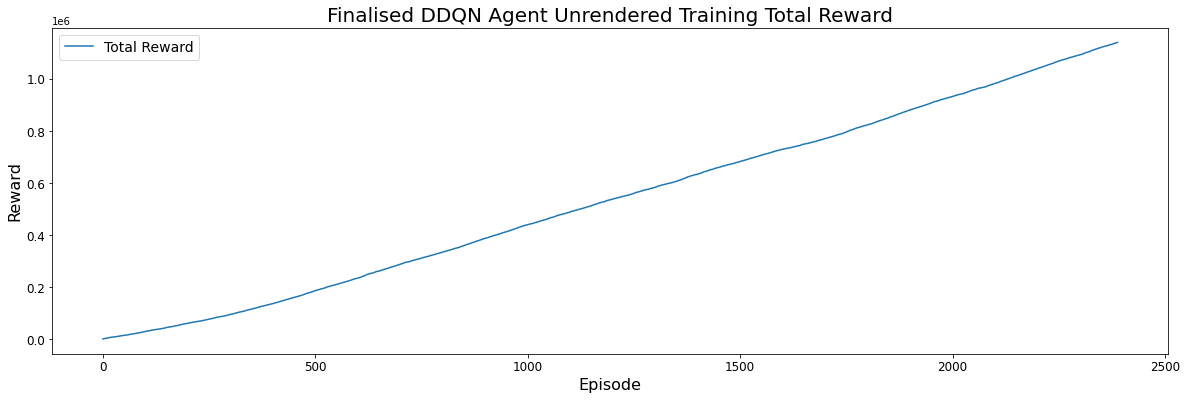

In [31]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df,
        cols=['Total Reward'], 
        x_label='Episode', 
        y_label='Reward',
        title='Image DDQN Agent Training Total Reward')

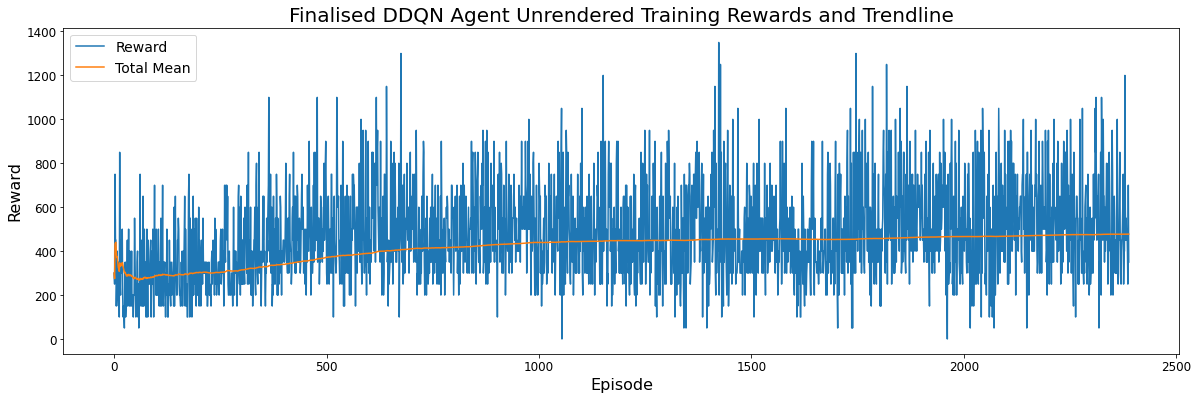

In [32]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Reward', 'Total Mean'], 
        x_label='Episode', 
        y_label='Reward',
        title='Image DDQN Agent Training Rewards and Trendline')

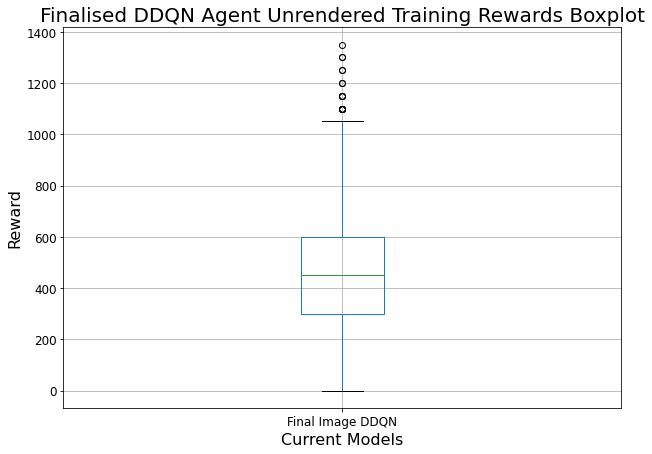

In [35]:
# Display a boxplot of the DDQN agent training data (agent rewards)
plot_boxplot_for_episodes(train_df, 
                          ['Reward'], 
                          ['DDQN-Image'], 
                          x_label='Current Steps (50K)', 
                          y_label='Reward', 
                          title='Image DDQN Agent Training Rewards BoxPlot for each 50,000 steps')

In [ ]:
plot_violinplot_for_episodes(train_df, 
                             ['Reward'], 
                             ['DDQN-Image'], 
                             x_label='Current Steps (50K)', 
                             y_label='Reward', 
                             title='Image DDQN Agent Training Rewards ViolinPlot for each 50,000 steps')

In [18]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('results/current_model.csv')

In [ ]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
ddqn_online = ddqn_agent.online
ddqn_online.save('image_ddqn_online_final_unrendered.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
ddqn_target = ddqn_agent.target
ddqn_target.save('image_ddqn_target_final_unrendered.h5')  

### Architecture

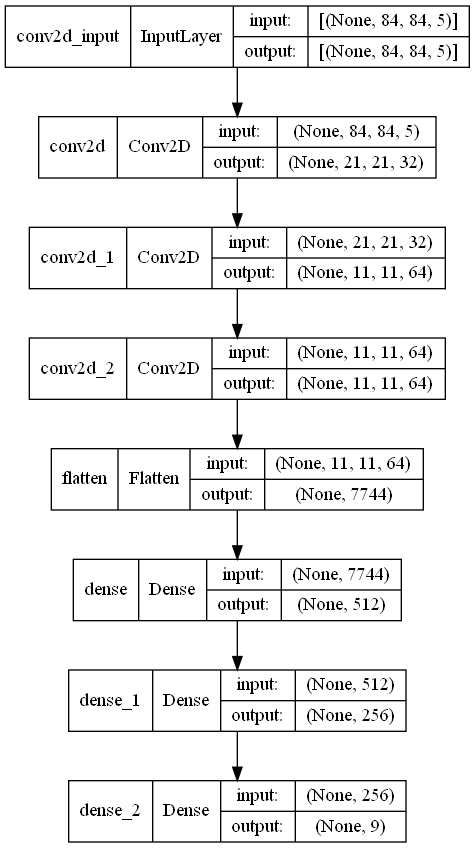

In [7]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
# !pip install pydot
# !pip install graphviz
# ddqn_online = load_model('image_ddqn_online_final_unrendered.h5')
# ddqn_online.summary()
plot_model(ddqn_online, to_file="architectures/ddqn_final.png", show_shapes=True)